# Simulations with effective noises

## Introduction
On the tutorial `Simulating sequences with errors and noises`, we introduced effective noise channels and here we will go in deeper details. If you missed that tutorial, please go back there before going through this one.

Effective noise model is based on the concept of Kraus operators which are actors in the Lindblad equation. If you're not familiar with Lindblad equations and want to know deeper, please check this ressource [here](https://ocw.mit.edu/courses/22-51-quantum-theory-of-radiation-interactions-fall-2012/resources/mit22_51f12_ch8/).

We recall the Lindblad equation:

$$
\frac{d \rho}{dt} = -i[\mathcal{H}, \rho] + \sum_k \left( L_k \rho L_k^\dagger - \frac{1}{2} \left\{ L_k^\dagger L_k, \rho \right\} \right)$$ 

Operators $L_k$ are what we call *Collapse operators*. Basically, effective noise channel can be fully described by a set of collapse operators which are linked with each other by an equation called the *completeness relationship*:  $\sum_k N_k N_k^\dagger = \mathbb{I}$.

So varying $N_k$ gives birth to different effective noise channels. We will discuss in this tutorial two specific ones:

* The dephasing channel
* The depolarizing channel


In [1]:
import qutip
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from pulser import Pulse, Sequence, Register
from pulser_simulation import Simulation, SimConfig
from pulser_simulation.simresults import (
    CoherentResults,
    NoisyResults,
    SimulationResults,
)
from pulser.waveforms import RampWaveform
from pulser.devices import Chadoq2
from pulser.devices._device_datacls import Device
from typing import Union, cast

## Effective noise channels

### The dephasing channel


Dephasing, or transverse relaxation, is the phenomenon associated with the decay of the coherence terms (off-diagonals)in the density matrix without loss of energy.

The dephasing noise can be thought as arising from random z rotation across the sample, from which we derived the corresponding collapse operators:

$M_0 = \sqrt{1-\frac{p}{2}} \mathbb{I}$ and $M_1 = \sqrt{\frac{p}{2}} \sigma_z$

### The Depolarizing channel

The depolarizing channel is a model of a decohering qubit that has particularly nice symmetry properties. We can describe it by saying that, with probability 1 -p the qubit remains intact, while with probability p an “error”occurs. The error can be of any one of four types, where each type of error is equally likely. If $(\ket{0},\ket{1})$ is an orthonormal basis for the qubit, the four types of errors can be characterized as:

1. Bit-flip error: $\ket{\psi} \longrightarrow \sigma_x\psi $.
2. Phase-flip error: $\ket{\psi} \longrightarrow \sigma_z\psi $.
3. Both errors: $\ket{\psi} \longrightarrow \sigma_y\psi $.
4. Idle: $\ket{\psi} \longrightarrow \psi $


If an error occurs, then $\ket{\psi} $ evolves to an ensemble of the four states equally likely: $\sigma_x\psi $, $\sigma_y\psi $, $\sigma_z\psi $, $\psi $.

Some papers choose not to include the idle state amid the error states. It doesn't change that much the effects of the noise channel. We prefer to stick to the model of the depolarizing channel presented in [Nielsen and Chuang](https://www.cambridge.org/highereducation/books/quantum-computation-and-quantum-information/01E10196D0A682A6AEFFEA52D53BE9AE#overview) book.

The underlying collapse operators are then:

$$
M_0 = \sqrt{1-\frac{3}{4}p} \,\, \mathbb{I}, \\
M_1 = \sqrt{\frac{p}{4}} \sigma_x, \\
M_2 = \sqrt{\frac{p}{4}}\sigma_z, \\
M_3 = \sqrt{\frac{p}{4}} \sigma_y$$

## Single atom noise simulation

In this section we will study the impact of effective noise channels on a single qubit under a resonant pulse.

We prepare a single atom

In [2]:
reg = Register.from_coordinates([(0, 0)], prefix="q")

Act on this atom with a Constant Pulse, such that it oscillates towards the excited Rydberg state and back to the original state (Rabi oscillations):

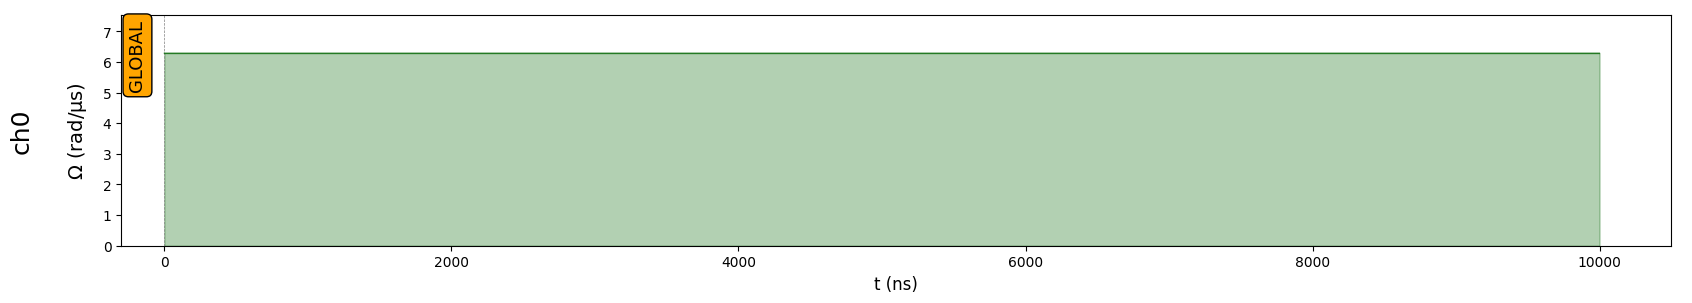

In [3]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ch0", "rydberg_global")
duration = 10000
pulse = Pulse.ConstantPulse(duration, 2 * np.pi, 0 * np.pi, 0.0)
seq.add(pulse, "ch0")
seq.draw()

We now run the noiseless simulation

In [4]:
clean_simu = Simulation(seq, sampling_rate=0.05)
clean_res = clean_simu.run()

We can observe the population on the ground state using it's projector

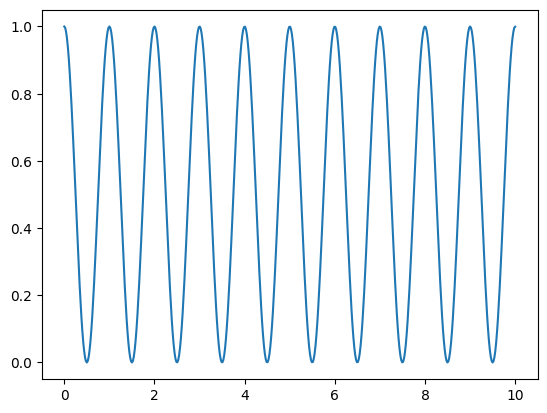

In [5]:
obs = clean_simu.initial_state.proj()
plt.plot(clean_res._sim_times, clean_res.expect([obs])[0])
plt.show()

The are two ways to define the dephasing and depolarizing channels on pulser.

The first way is by creating a `SimConfig` object, specifying you want the dephasing noise and choosing the *dephasing probability*

In [6]:
config_dephasing = SimConfig(noise="dephasing", dephasing_prob=0.1)
clean_simu.set_config(config_dephasing)
clean_simu.show_config()

Options:
----------
Number of runs:        15
Samples per run:       5
Noise types:           dephasing
Dephasing probability: 0.1


In [7]:
clean_simu.reset_config()
config_depolarizing = SimConfig(noise="depolarizing", depolarizing_prob=0.1)
clean_simu.set_config(config_depolarizing)
clean_simu.show_config()

Options:
----------
Number of runs:        15
Samples per run:       5
Noise types:           depolarizing
Depolarizing probability: 0.1


The second way, which is a more general way, allows not only to describe the dephasing noise, but also all effective noise channels.

In [8]:
clean_simu.reset_config()
config_dephasing = SimConfig(
    noise="eff_noise",
    eff_noise_opers=[qutip.qeye(2), qutip.sigmaz()],
    eff_noise_probs=[1 - 0.05, 0.05],
)
clean_simu.add_config(config_dephasing)
clean_simu.show_config()

Options:
----------
Number of runs:        15
Samples per run:       5
Noise types:           eff_noise
Effective noise distribution:       [0.95, 0.05]
Effective noise operators:       [Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]]


This is more explicit than the first method since we see the operators corresponding to the effective noise channel. In the case of the *dephasing channel*, the operators are: $\mathbb{I}$ and $\sigma_z$, which is what we see at the right of `Effective noise operators`.

Note that if you want to design other effective noise channels like the `amplitude damping` or `phase damping`. You need to use the `eff_noise` noise parameter and define directly your collapse operators. There are no specific noise settings on pulser for these channels as for the `dephasing` and `depolarizing` channels.

We need clean the simulation for future usage

In [9]:
clean_simu.reset_config()
clean_simu.show_config()

Options:
----------
Number of runs:        15
Samples per run:       5


Let us now simulate the entire sequence with our two effective noise channels.

We define some useful functions for our simulations.

In [10]:
def get_population(rho, psi_0):
    """
    Expectation value of the input density matrix over a given direction psi_0
    """
    return np.real(psi_0.dag() * rho * psi_0)


def get_population_evolution(result: SimulationResults, state):
    """
    Evolution of the expectation value of the density matrix along a state over time
    """
    population = []
    for rho_t in result.states:
        population.append(get_population(rho_t, state)[0][0])
    return population


def noisy_dynamics(clean_simu: Simulation, config: SimConfig):
    """
    Noisy simulation and metrics
    """
    simu = deepcopy(clean_simu)
    # Adding noise
    simu.add_config(config)
    result = simu.run()
    return result

Then we run our simulations

In [11]:
noise_probabilities = np.linspace(0, 1, 5)
depolarizing_results = []
dephasing_results = []
dephasing_gaps = []
depolarizing_gaps = []

for noise_probability in noise_probabilities:
    print("Noise probability = ", noise_probability)

    # Configure the dephasing noise and run simulation
    config_dephasing = SimConfig(
        noise="dephasing", dephasing_prob=noise_probability
    )
    config_depolarizing = SimConfig(
        noise="depolarizing", depolarizing_prob=noise_probability
    )

    dephasing_result = noisy_dynamics(clean_simu, config_dephasing)
    depolarizing_result = noisy_dynamics(clean_simu, config_depolarizing)

    # Gap from the no noise config
    dephasing_gap = []
    depolarizing_gap = []
    for i in range(len(depolarizing_result.states)):
        dephasing_gap.append(
            qutip.tracedist(clean_res.states[i], dephasing_result.states[i])
        )
        depolarizing_gap.append(
            qutip.tracedist(clean_res.states[i], depolarizing_result.states[i])
        )

    # Storage
    depolarizing_results.append(depolarizing_result)
    dephasing_results.append(dephasing_result)
    dephasing_gaps.append(dephasing_gap)
    depolarizing_gaps.append(depolarizing_gap)

Noise probability =  0.0
Noise probability =  0.25
Noise probability =  0.5
Noise probability =  0.75
Noise probability =  1.0


### Dephasing Channel

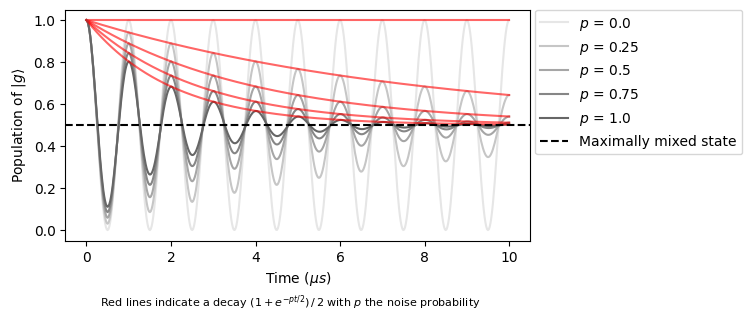

In [12]:
# Ground state population with dephasing noise
psi_0 = clean_simu.initial_state
dephasing_pops = [
    get_population_evolution(dephasing_result, state=psi_0)
    for dephasing_result in dephasing_results
]
times = dephasing_results[0]._sim_times

plt.figure(figsize=(6, 3))
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"Population of $|g\rangle$")

for noise_probability, dephasing_pop in zip(
    noise_probabilities, dephasing_pops
):
    plt.plot(
        times,
        dephasing_pop,
        label=rf"$p$ = {noise_probability}",
        color=[0.9 - 0.5*noise_probability] * 3,
    )
    plt.plot(
        times,
        0.5 * (1 + np.exp(-0.5 * noise_probability * times)),
        #label=rf"Decay with p={noise_probability}",
        color="red",
        alpha=0.6
    )

plt.axhline(0.5, color="black", linestyle="--", label="Maximally mixed state")
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0.0)

# Add caption:
plt.figtext(
    0.5, -0.11,
    r"Red lines indicate a decay $(1 + e^{-p t/2})\, /\,2$ with $p$ the noise probability",
    horizontalalignment="center",
    fontsize=8,
)
plt.show()

When we look at how the population at the ground state evolves with respect to the depahsing probability $p$, we notice that it converges to a stationary value, $0.5$.

It's an exponential damping. We ploted the corresponding exponential damping.

The dephasing noise can be thought as arising from random z rotation across the sample, so that the state of the
system can be described by a statistical average over a distribution of rotation angles $q(\nu) $:

$S_d(\rho) = \int d\nu q(\nu)e^{-\frac{\nu}{2}\sigma_z}\rho(0)e^{\frac{\nu}{2}\sigma_z} $

From this equation we can derive the following relationship:

$S_d(\rho) = \frac{1 + \Gamma}{2}\rho + \frac{1 - \Gamma}{2} \sigma_z \rho \sigma_z$, $\Gamma = e^{-\frac{t}{T_2}}$ 

$T_2$ is what we call the dephasing time. It describes how long the state remains intact. Be careful, it is not "the time from state x to state y".

With $\frac{t}{T_2} \lll 1 $, $\Gamma = e^{-\frac{t}{T_2}} \approx 1 -\frac{t}{T_2} = 1 - \gamma $. The underlying dephasing channel remains:

$S_d(\rho) = (1 - \frac{\gamma}{2})\rho + \frac{\gamma}{2} \sigma_z \rho \sigma_z = (1 - \frac{p}{2})\rho + \frac{p}{2} \sigma_z \rho \sigma_z$. Now appears our well-known dephasing probability $p$.

With $\rho = \ket{+}\bra{+} $, we have $\bra{+}S_d(\rho)\ket{+} = \frac{1 + \Gamma}{2} = \frac{1 + e^{-\frac{t}{T_2}}}{2} = \frac{1 + e^{-\gamma t}}{2} = \frac{1 + e^{-\frac{p}{2}t}}{2} = p_+ $

It refers to the probability, starting from the $\ket{+} $ state to end in the $\ket{+} $ state.

It happens to be the profile of the decay of the all-ground population. The system converges to the density matrix $\rho = \frac{1}{2} \mathbb I$.

This is a statistical mixture of $|0\rangle$ and $|1\rangle$: $\rho = \frac{1}{2}(|0\rangle\langle 0| + |1\rangle\langle 1|)$.

In [13]:
# Final state
dephasing_results[-1].states[-1]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.49679069+0.j         0.        +0.00083748j]
 [0.        -0.00083748j 0.50320931+0.j        ]]

### Depolarizing Channel

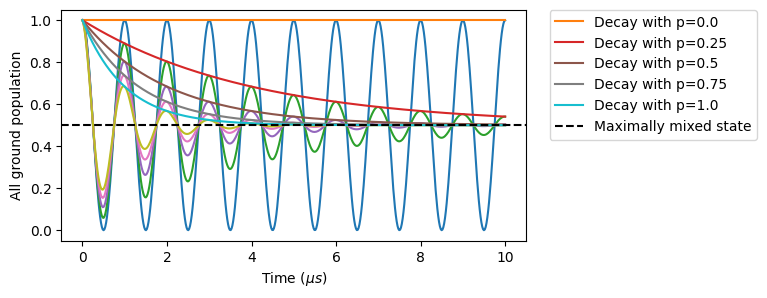

In [14]:
# Ground state population with depolarizing noise
psi_0 = clean_simu.initial_state
depolarizing_pops = [
    get_population_evolution(depolarizing_result, state=psi_0)
    for depolarizing_result in depolarizing_results
]
times = depolarizing_results[0]._sim_times

plt.figure(figsize=(6, 3))
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel("All ground population")

for noise_probability, depolarizing_pop in zip(
    noise_probabilities, depolarizing_pops
):
    plt.plot(
        times,
        depolarizing_pop,
        #label=f"Depolarizing probability = {noise_probability}",
    )
    plt.plot(
        times,
        0.5 * np.exp(-noise_probability * times) + 0.5,
        label=f"Decay with p={noise_probability}",
    )

plt.axhline(0.5, color="black", linestyle="--", label="Maximally mixed state")

# put labels outside of the plot:
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)


We also observe a damping of the population amplitude. The damping is more pronounced than the dephasing channel.

To have a better view of the impact of the depolarizing channel, we will use the bloch sphere representation of the density matrix.

### Bloch Sphere Representation

Any density matrix of a mixed state qubit may be written as follows: $\rho = \frac{\mathbb{I} + \vec{r}.\vec{\sigma}}{2} $

$\vec{r} $ is the vector representing the mixed state in the Bloch Sphere

In [15]:
def point_to_dm(r_x, r_y, r_z):
    """
    Transform a vector in the Bloch sphere into a density matrix
    """

    return 0.5 * (
        qutip.qeye(2)
        + r_x * qutip.sigmax()
        + r_y * qutip.sigmay()
        + r_z * qutip.sigmaz()
    )


def dm_to_point(rho):
    """
    From a mixed state rho returns the corresponding point
    """

    I = 2 * rho - np.eye(2)
    r_x = np.real((I[0, 1] + I[1, 0]) / 2)
    r_y = np.real((I[1, 0] - I[0, 1]) / 2)
    r_z = np.real(I[0, 0])

    return r_x, r_y, r_z


def depolarizing_channel(rho, prob):

    return (1 - 3 * prob / 4) * rho + prob / 4 * (
        qutip.sigmax() * rho * qutip.sigmax()
        + qutip.sigmay() * rho * qutip.sigmay()
        + qutip.sigmaz() * rho * qutip.sigmaz()
    )

Let's choose few points in the Bloch sphere

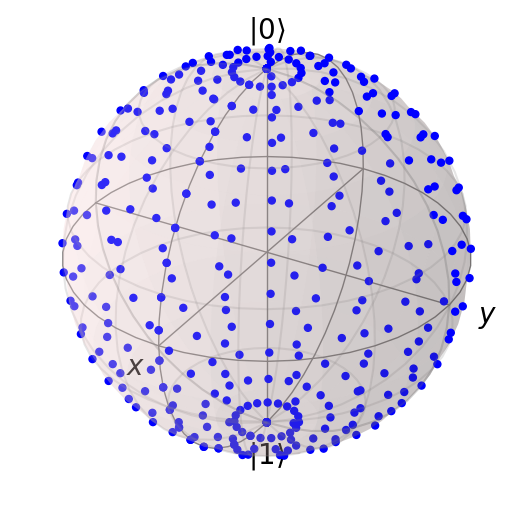

In [16]:
u = np.linspace(0, 2 * np.pi, 20)
v = np.linspace(0, np.pi, 20)
r = 1
n = len(u)
# x, y, z coordinates with fixed radius r from center X0, Y0, Z0

x = r * np.reshape(np.outer(np.cos(u), np.sin(v)), newshape=(n**2, 1))
y = r * np.reshape(np.outer(np.sin(u), np.sin(v)), newshape=(n**2, 1))
z = r * np.reshape(
    np.outer(np.ones(np.size(u)), np.cos(v)), newshape=(n**2, 1)
)

b = qutip.Bloch()
points = [x, y, z]
b.add_points(points)
b.show()

Now let's observe the effect of the depolarizing channel on these points

In [17]:
depolarizing_prob = 0.5
x_dp = x
y_dp = y
z_dp = z
n, p = x.shape
for i in range(n):
    for j in range(p):
        dm = point_to_dm(x[i, j], y[i, j], z[i, j])
        dm_n = depolarizing_channel(dm, depolarizing_prob)
        r_x, r_y, r_z = dm_to_point(dm_n)
        x_dp[i, j] = r_x
        y_dp[i, j] = r_y
        z_dp[i, j] = r_z

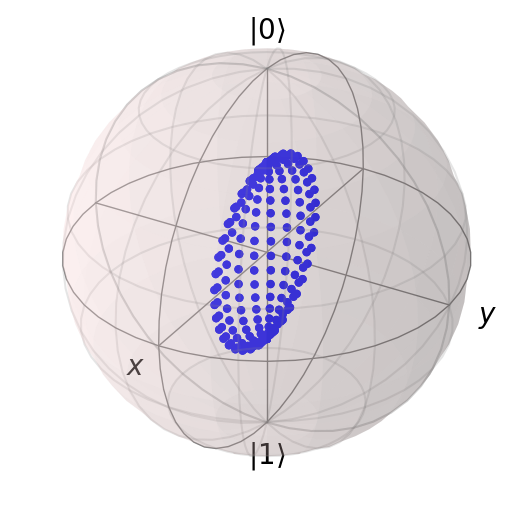

In [18]:
b = qutip.Bloch()
points = [x_dp, y_dp, z_dp]
b.add_points(points)
b.show()

The depolarizing channel contracts the Bloch sphere across all the directions.

### 2-qubit case

We already know what happen in a single qubit configuration. But we would like to study the multi-qubit case. To do so we start with two qubits.

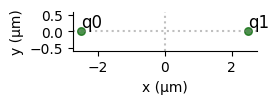

In [19]:
reg = Register.from_coordinates([(0, 0), (5, 0)], prefix="q")

reg.draw()

We will use the same simple pulse

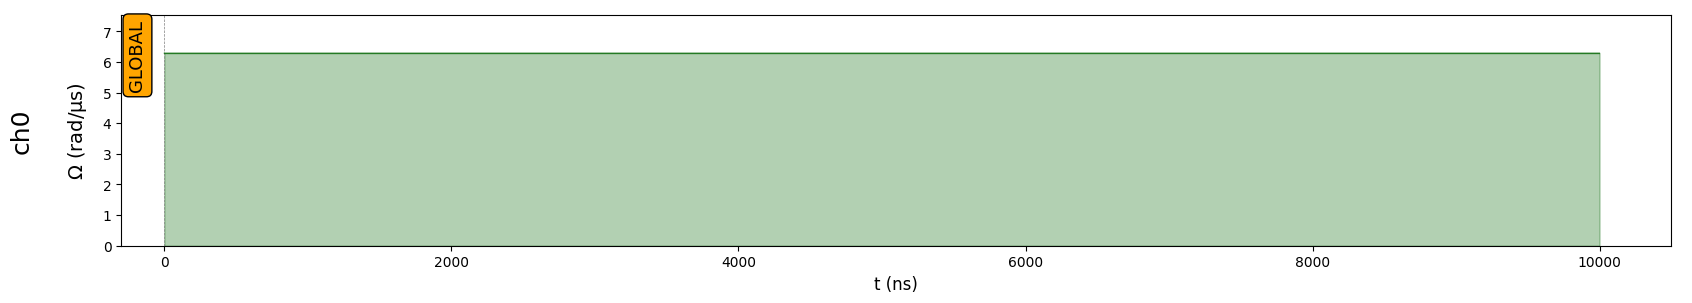

In [20]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ch0", "rydberg_global")
duration = 10000
omega = 2 * np.pi
pulse = Pulse.ConstantPulse(duration, omega, 0, 0.0)
seq.add(pulse, "ch0")
seq.draw()

In [21]:
# Rydberg blockade radius
R_interatomic = Chadoq2.rydberg_blockade_radius(omega)
R_interatomic

9.756753962298905

So our two atoms are in the blockade radius. Let's keep it in mind.

An important detail needs to be mentioned. In the multi-qubit case, we made an assumption, we called it, the *uncorrelated noise approximation*. It relies on the fact that the probability of two qubits to undergo an effective noise are independent, i.e:$\\$
$Pr(q_i = Nq_i, q_j= Nq_j) = Pr(q_i = Nq_i) Pr(q_j = Nq_j)$, $\forall i,j$ where $N$ is a noise operator.

Let's take $p = Pr(q_i = Nq_i), \forall i$, and $m$ the number of qubit noised, the underlying probability is $p^m$. Therefore, if $p\ll 1$ we get: $p^m \longrightarrow 0$

So the more likely states are: $Nq_j\otimes_{i\neq j}q_i, \forall j$ all equiprobable.

In [22]:
clean_simu = Simulation(seq, sampling_rate=0.05)
clean_res = clean_simu.run()

When an effective noise probability is higher than $0.2$, we get a warning

In [23]:
config = SimConfig(noise="dephasing", dephasing_prob=0.5)
clean_simu.add_config(config)

/Users/seb/Documents/Projects/pasqal/Internship/pulser/pulser-simulation/pulser_simulation/simulation.py:349: UserWarning: The dephasing model is a first-order approximation in the dephasing probability. p = 0.5 is too large for realistic results.
  self.set_config(SimConfig(**param_dict))


### Dephasing channel

In [24]:
clean_simu.reset_config()
noise_probabilities = np.linspace(0, 1, 5)
depolarizing_results = []
dephasing_results = []
dephasing_gaps = []
depolarizing_gaps = []

for noise_probability in noise_probabilities:
    print("Noise probability = ", noise_probability)

    # Configure the dephasing noise and run simulation
    config_dephasing = SimConfig(
        noise="dephasing", dephasing_prob=noise_probability
    )
    config_depolarizing = SimConfig(
        noise="depolarizing", depolarizing_prob=noise_probability
    )

    dephasing_result = noisy_dynamics(clean_simu, config_dephasing)
    depolarizing_result = noisy_dynamics(clean_simu, config_depolarizing)

    # Gap from the no noise config
    dephasing_gap = []
    depolarizing_gap = []
    for i in range(len(depolarizing_result.states)):
        dephasing_gap.append(
            qutip.tracedist(clean_res.states[i], dephasing_result.states[i])
        )
        depolarizing_gap.append(
            qutip.tracedist(clean_res.states[i], depolarizing_result.states[i])
        )

    # Storage
    depolarizing_results.append(depolarizing_result)
    dephasing_results.append(dephasing_result)
    dephasing_gaps.append(dephasing_gap)
    depolarizing_gaps.append(depolarizing_gap)

Noise probability =  0.0
Noise probability =  0.25


/Users/seb/Documents/Projects/pasqal/Internship/pulser/pulser-simulation/pulser_simulation/simulation.py:349: UserWarning: The dephasing model is a first-order approximation in the dephasing probability. p = 0.25 is too large for realistic results.
  self.set_config(SimConfig(**param_dict))


Noise probability =  0.5


/Users/seb/Documents/Projects/pasqal/Internship/pulser/pulser-simulation/pulser_simulation/simulation.py:349: UserWarning: The depolarizing model is a first-order approximation in the depolarizing probability. p = 0.5 is too large for realistic results.
  self.set_config(SimConfig(**param_dict))


Noise probability =  0.75


/Users/seb/Documents/Projects/pasqal/Internship/pulser/pulser-simulation/pulser_simulation/simulation.py:349: UserWarning: The dephasing model is a first-order approximation in the dephasing probability. p = 0.75 is too large for realistic results.
  self.set_config(SimConfig(**param_dict))
/Users/seb/Documents/Projects/pasqal/Internship/pulser/pulser-simulation/pulser_simulation/simulation.py:349: UserWarning: The depolarizing model is a first-order approximation in the depolarizing probability. p = 0.75 is too large for realistic results.
  self.set_config(SimConfig(**param_dict))


Noise probability =  1.0


/Users/seb/Documents/Projects/pasqal/Internship/pulser/pulser-simulation/pulser_simulation/simulation.py:349: UserWarning: The dephasing model is a first-order approximation in the dephasing probability. p = 1.0 is too large for realistic results.
  self.set_config(SimConfig(**param_dict))
/Users/seb/Documents/Projects/pasqal/Internship/pulser/pulser-simulation/pulser_simulation/simulation.py:349: UserWarning: The depolarizing model is a first-order approximation in the depolarizing probability. p = 1.0 is too large for realistic results.
  self.set_config(SimConfig(**param_dict))


#### Population Evolution

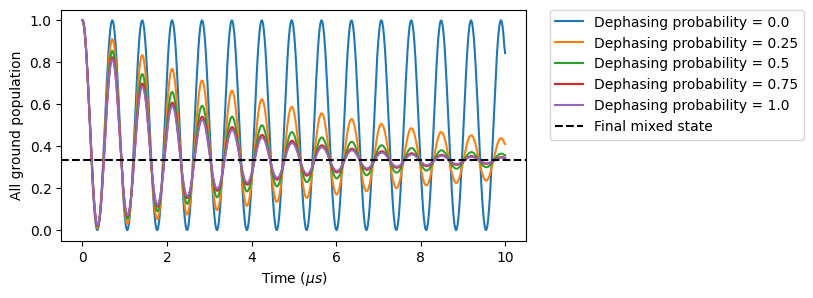

In [25]:
# Ground state population with dephasing noise
psi_0 = clean_simu.initial_state
dephasing_pops = [
    get_population_evolution(dephasing_result, state=psi_0)
    for dephasing_result in dephasing_results
]
times = dephasing_results[0]._sim_times

plt.figure(figsize=(6, 3))
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel("All ground population")

for noise_probability, dephasing_pop in zip(
    noise_probabilities, dephasing_pops
):
    plt.plot(
        times,
        dephasing_pop,
        label=f"Dephasing probability = {noise_probability}",
    )

plt.axhline(1 / 3, color="black", linestyle="--", label="Final mixed state")

# put labels outside of the plot:
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.show()

Normally, $p>0.2$ is out of our approximation. But in order to see clearly where the population converges, we plotted some samples for $p>0.2$.

Empirically we found that: $\braket{g|\rho(t)|g} $ converges to $\frac{1}{3} $. To verify it let's plot the exited state population.

The effects seems to be the same as that we observed in the single qubit case. Let's increase the distance between qubit

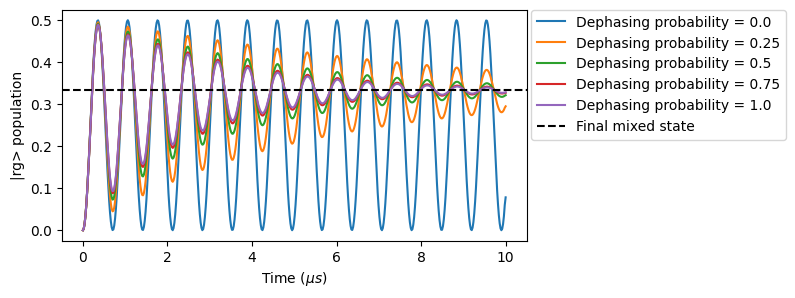

In [26]:
psi_1 = qutip.basis(2, 0)
psi_0 = qutip.basis(2, 1)
psi = qutip.tensor(psi_0, psi_1)
dephasing_pops = [
    get_population_evolution(dephasing_result, state=psi)
    for dephasing_result in dephasing_results
]
times = dephasing_results[0]._sim_times

plt.figure(figsize=(6, 3))
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel("|rg> population")

for noise_probability, dephasing_pop in zip(
    noise_probabilities, dephasing_pops
):
    plt.plot(
        times,
        dephasing_pop,
        label=f"Dephasing probability = {noise_probability}",
    )

plt.axhline(1 / 3, color="black", linestyle="--", label="Final mixed state")

# put labels outside of the plot:
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0.0)
plt.show()

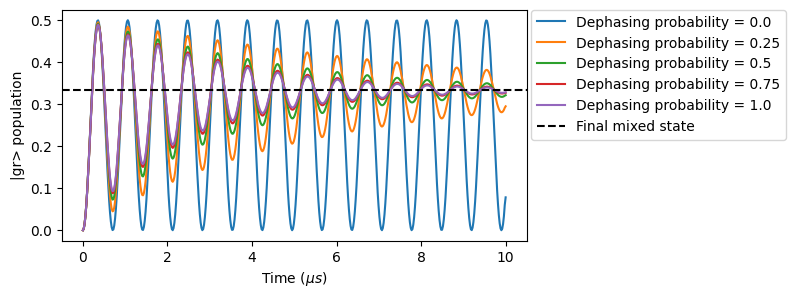

In [27]:
psi_1 = qutip.basis(2, 1)
psi_0 = qutip.basis(2, 0)
psi = qutip.tensor(psi_0, psi_1)
dephasing_pops = [
    get_population_evolution(dephasing_result, state=psi)
    for dephasing_result in dephasing_results
]
times = dephasing_results[0]._sim_times

plt.figure(figsize=(6, 3))
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel("|gr> population")

for noise_probability, dephasing_pop in zip(
    noise_probabilities, dephasing_pops
):
    plt.plot(
        times,
        dephasing_pop,
        label=f"Dephasing probability = {noise_probability}",
    )

plt.axhline(1 / 3, color="black", linestyle="--", label="Final mixed state")

# put labels outside of the plot:
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0.0)
plt.show()

The final mixed states is then: 

$\rho = \frac{1}{3} (\ket{gg}\bra{gg} + \ket{gr}\bra{gr} + \ket{rg}\bra{rg} ) $

The Rydberg blockades prevent the simultaneous exitation of the two qubits: the dephasing "respects the blockade effect." Let's see how does the depolarizing channel interfers.

### Depolarizing channel

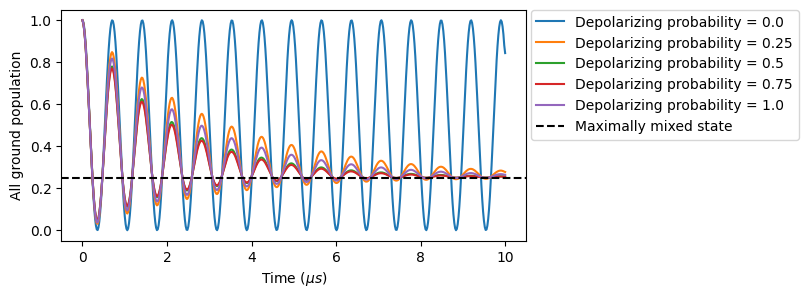

In [28]:
# Ground state population with depolarizing noise
psi_0 = clean_simu.initial_state
depolarizing_pops = [
    get_population_evolution(depolarizing_result, state=psi_0)
    for depolarizing_result in depolarizing_results
]
times = depolarizing_results[0]._sim_times

plt.figure(figsize=(6, 3))
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel("All ground population")

for noise_probability, depolarizing_pop in zip(
    noise_probabilities, depolarizing_pops
):
    plt.plot(
        times,
        depolarizing_pop,
        label=f"Depolarizing probability = {noise_probability}",
    )

plt.axhline(0.25, color="black", linestyle="--", label="Maximally mixed state")

# put labels outside of the plot:
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0.0)
plt.show()

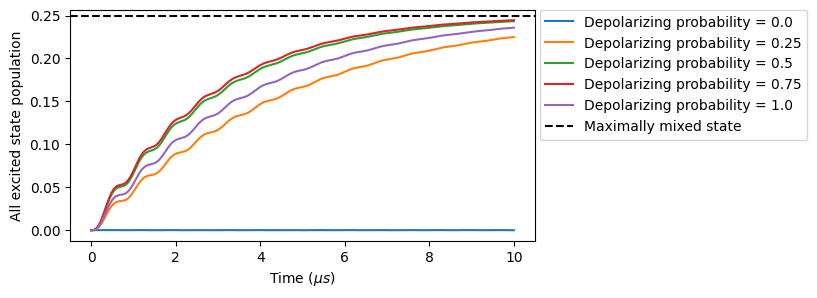

In [29]:
# All excited state population with depolarizing noise
psi_1 = qutip.basis(2, 0)
psi_0 = qutip.basis(2, 0)
psi = qutip.tensor(psi_0, psi_1)
depolarizing_pops = [
    get_population_evolution(depolarizing_result, state=psi)
    for depolarizing_result in depolarizing_results
]
times = depolarizing_results[0]._sim_times

plt.figure(figsize=(6, 3))
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel("All excited state population")

for noise_probability, depolarizing_pop in zip(
    noise_probabilities, depolarizing_pops
):
    plt.plot(
        times,
        depolarizing_pop,
        label=f"Depolarizing probability = {noise_probability}",
    )

plt.axhline(0.25, color="black", linestyle="--", label="Maximally mixed state")

# put labels outside of the plot:
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0.0)
plt.show()

Because of the Rydberg blockade, the state $\ket{rr} $ state is supposed to be unreachable. This is why we observe with the blue curve where the depolarizing probability is zero. 
But, after exposing the system to the depolarized channel the blockade is broken and the output mixed state is:

$\rho = \frac{1}{4} (\ket{gg}\bra{gg} + \ket{gr}\bra{gr} + \ket{rg}\bra{rg} + \ket{rr}\bra{rr}) $
This is a distinctive difference from the dephasing channel we were not able to observe with one qubit.

Let's look at the case of distant qubits

In [30]:
reg = Register.from_coordinates([(0, 0), (20, 0)], prefix="q")

print(f"20 = R > Ryderg radius = {R_interatomic} ")
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ch0", "rydberg_global")
duration = 10000
pulse = Pulse.ConstantPulse(duration, 2 * np.pi, 0 * np.pi, 0.0)
seq.add(pulse, "ch0")

20 = R > Ryderg radius = 9.756753962298905 


The blockade effect is broken.

In [31]:
clean_simu = Simulation(seq, sampling_rate=0.05)
clean_res = clean_simu.run()
noise_probabilities = np.linspace(0, 1, 5)
depolarizing_results = []
dephasing_results = []
dephasing_gaps = []
depolarizing_gaps = []

for noise_probability in noise_probabilities:
    print("Noise probability = ", noise_probability)

    # Configure the dephasing noise and run simulation
    config_dephasing = SimConfig(
        noise="dephasing", dephasing_prob=noise_probability
    )
    config_depolarizing = SimConfig(
        noise="depolarizing", depolarizing_prob=noise_probability
    )

    dephasing_result = noisy_dynamics(clean_simu, config_dephasing)
    depolarizing_result = noisy_dynamics(clean_simu, config_depolarizing)

    # Gap from the no noise config
    dephasing_gap = []
    depolarizing_gap = []
    for i in range(len(depolarizing_result.states)):
        dephasing_gap.append(
            qutip.tracedist(clean_res.states[i], dephasing_result.states[i])
        )
        depolarizing_gap.append(
            qutip.tracedist(clean_res.states[i], depolarizing_result.states[i])
        )

    # Storage
    depolarizing_results.append(depolarizing_result)
    dephasing_results.append(dephasing_result)
    dephasing_gaps.append(dephasing_gap)
    depolarizing_gaps.append(depolarizing_gap)

Noise probability =  0.0
Noise probability =  0.25
Noise probability =  0.5
Noise probability =  0.75
Noise probability =  1.0


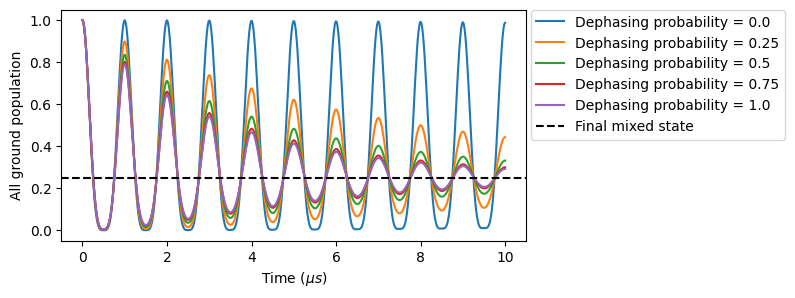

In [32]:
# Ground state population with dephasing noise
psi_0 = clean_simu.initial_state
dephasing_pops = [
    get_population_evolution(dephasing_result, state=psi_0)
    for dephasing_result in dephasing_results
]
times = dephasing_results[0]._sim_times

plt.figure(figsize=(6, 3))
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel("All ground population")

for noise_probability, dephasing_pop in zip(
    noise_probabilities, dephasing_pops
):
    plt.plot(
        times,
        dephasing_pop,
        label=f"Dephasing probability = {noise_probability}",
    )

plt.axhline(0.25, color="black", linestyle="--", label="Final mixed state")

# put labels outside of the plot:
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0.0)
plt.show()

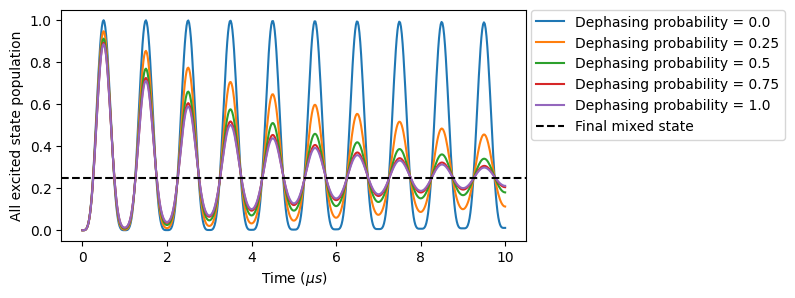

In [33]:
# Excited state population with noise
psi_0 = qutip.basis(2, 0)
psi_1 = qutip.basis(2, 0)
psi = qutip.tensor(psi_0, psi_1)
dephasing_pops = [
    get_population_evolution(dephasing_result, state=psi)
    for dephasing_result in dephasing_results
]
times = dephasing_results[0]._sim_times

plt.figure(figsize=(6, 3))
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel("All excited state population")

for noise_probability, dephasing_pop in zip(
    noise_probabilities, dephasing_pops
):
    plt.plot(
        times,
        dephasing_pop,
        label=f"Dephasing probability = {noise_probability}",
    )

plt.axhline(0.25, color="black", linestyle="--", label="Final mixed state")

# put labels outside of the plot:
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0.0)
plt.show()

We obtain a non-zero population in the $\ket{rr} $ state as expected since atom 2 is outside the Blockade radius. The output mixed state we obtain is:

$\rho = \frac{1}{4} (\ket{gg}\bra{gg} + \ket{gr}\bra{gr} + \ket{rg}\bra{rg} + \ket{rr}\bra{rr}) $

Depolarizing

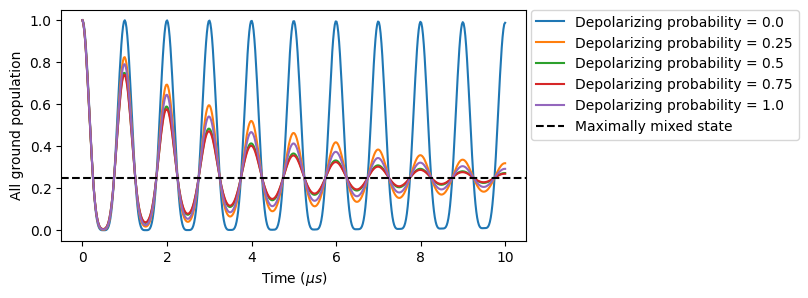

In [34]:
# Ground state population with depolarizing noise
psi_0 = clean_simu.initial_state
depolarizing_pops = [
    get_population_evolution(depolarizing_result, state=psi_0)
    for depolarizing_result in depolarizing_results
]
times = depolarizing_results[0]._sim_times

plt.figure(figsize=(6, 3))
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel("All ground population")

for noise_probability, depolarizing_pop in zip(
    noise_probabilities, depolarizing_pops
):
    plt.plot(
        times,
        depolarizing_pop,
        label=f"Depolarizing probability = {noise_probability}",
    )

plt.axhline(0.25, color="black", linestyle="--", label="Maximally mixed state")

# put labels outside of the plot:
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0.0)
plt.show()

We can't expect more than the dephasing channel in this case since there is no Blockade effect. The output mixed state remains:

$\rho = \frac{1}{4} (\ket{gg}\bra{gg} + \ket{gr}\bra{gr} + \ket{rg}\bra{rg} + \ket{rr}\bra{rr}) $

While driving atoms from $\ket{g} $ to $\ket{r} $, with a resonant pulse($\delta $ = 0), the dephasing channel leads the system to an equiprobable mixture of all reachable basis states.

When there is a Rydberg blockade, the three basis states left are: $\ket{gg} $, $\ket{gr} $ and $\ket{rg} $. And the output state was: $\frac{1}{3} (\ket{gg} + \ket{gr} + \ket{rg}) $. Whereas, the depolarizing channel breaks the blockade and makes available the all-excited state.

And here since the blockade is broken, the system undergoing either the depolarizing channel or the dephasing channel, can reach the all-exited state $\ket{rr} $ leading the output mixed state to: $\frac{1}{4} (\ket{gg} + \ket{gr} + \ket{rg} + \ket{rr})$